In [1]:
import os
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy

from sklearn import preprocessing, pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from isotree import IsolationForest
from sklearn import tree, ensemble
from cfmining.mip_algorithms import ForestRecourseActions
from cfmining.predictors import TreeClassifier

from cfmining.mip_algorithms import LinearRecourseActions, LinearRecourseActionsMulti
from cfmining.algorithms import MAPOCAM, BruteForce, Greedy, MAPOCAM2
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import MonotoneClassifier, GeneralClassifier, TreeClassifier, LinearClassifier, LinearRule, GeneralClassifier_Shap
from cfmining.action_set import ActionSet

from results import save_result

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

## Preparing dataset

In [3]:
data_dir = "data/"
data_name = 'german'
data_file = os.path.join(data_dir, '%s_processed.csv' % data_name)
## load and process data
german_df = pd.read_csv(data_file).reset_index(drop=True)
german_df = (german_df
             .assign(isMale=lambda df: (df['Gender']=='Male').astype(int))
             .drop(['PurposeOfLoan', 'Gender', 'OtherLoansAtStore'], axis=1)
            )

y = german_df['GoodCustomer']
# tranform y to [0, 1]
y = (y == 1).astype(int)
X = german_df.drop('GoodCustomer', axis=1)
X = X[['ForeignWorker', 'Single', 'Age', 'LoanDuration', 'LoanAmount', 'LoanRateAsPercentOfIncome', 'isMale', 'YearsAtCurrentHome',
'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone',]]

In [4]:
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=100)

In [10]:
#outlier_detection = IsolationForest(contamination=0.1, n_estimators=50)
outlier_detection = IsolationForest(ndim=1, sample_size=256, max_depth=8, ntrees=100, missing_action="fail")
outlier_detection.fit(Xtr);
print(np.unique(outlier_detection.predict(Xtr) > 0.6, return_counts=True))

(array([False,  True]), array([871,  29]))


## Models

In [11]:
stand = preprocessing.StandardScaler()
clf_base = LogisticRegression(max_iter=1000, class_weight='balanced')
clf = pipeline.Pipeline([('std', stand), ('clf', clf_base)])

grid = GridSearchCV(
  clf, param_grid={'clf__C': np.logspace(-4, 3)},
  cv=5,
  scoring='roc_auc',
  verbose=0
)

grid.fit(Xtr, ytr)
clf_lgr = grid.best_estimator_

clf_rt = ensemble.RandomForestClassifier(
  n_estimators=10, 
  max_depth=5, 
  max_leaf_nodes=31,
  class_weight='balanced_subsample'
)
clf_rt.fit(Xtr, ytr);

In [12]:
threshold=0.5
scores_lgr = pd.Series(clf_lgr.predict_proba(Xts)[:, 1])
denied_individuals_lgr = scores_lgr.loc[lambda s: s < threshold].index

scores_rt = pd.Series(clf_rt.predict_proba(Xts)[:, 1])
denied_individuals_rt = scores_rt.loc[lambda s: s < threshold].index

## Setting ActionSet base parameters

In [13]:
action_set_base = ActionSet(X = X)
for feat in action_set_base:
    if feat.name in ['Age', 'JobClassIsSkilled', 'OwnsHouse', 'isMale', 'JobClassIsSkilled']:
        feat.mutable = False
        feat.step_direction = 1
    if feat.name in ['Single', 'ForeignWorker', 'RentsHouse']:
        feat.mutable = False
        feat.step_direction = -1
    if feat.name in ['LoanDuration', 'LoanAmount', 'LoanRateAsPercentOfIncome', 'NumberOfOtherLoansAtBank', 'MissedPayments',
                     'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank', 'Unemployed', 'YearsAtCurrentJob_lt_1']:
        feat.mutable = True
        feat.step_direction = -1
    if feat.name in ['YearsAtCurrentHome', 'NumberOfLiableIndividuals', 'HasTelephone', 'CheckingAccountBalance_geq_0',
                     'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
                     'NoCurrentLoan', 'HasCoapplicant', 'HasGuarantor', 'YearsAtCurrentJob_geq_4']:
        feat.mutable = True
        feat.step_direction = 1
    
    feat.flip_direction = 1
    feat.update_grid()

In [14]:
action_set = copy.deepcopy(action_set_base)
action_set['Age'].mutable = False
action_set['Age'].update_grid()

action_set['LoanDuration'].step_type ="absolute"
action_set['LoanDuration'].step_size = 6
action_set['LoanDuration'].update_grid()

action_set['LoanAmount'].step_size = 0.1
action_set['LoanAmount'].update_grid()

print('ActionSet stats')
print('Number of actionable features:', sum([action.actionable for action in action_set]))
print('Mean number of actions per feature:', np.nanmean([len(action._grid) if action.actionable else np.nan for action in action_set]))
print('Max number of actions per feature:', np.nanmax([len(action._grid) if action.actionable else np.nan for action in action_set]))
log_combinations = int(np.prod([len(action._grid) for action in action_set if action_set.actionable]))
print('Number of combinations:', log_combinations)

ActionSet stats
Number of actionable features: 3
Mean number of actions per feature: 2.6666666666666665
Max number of actions per feature: 4.0
Number of combinations: 8279040


In [15]:
percCalc_lgr = PercentileCalculator(action_set=action_set)

In [16]:
action_set_tree = copy.deepcopy(action_set_base)
action_set_tree.embed_forest(clf_rt)
for action in action_set_tree:
    action.flip_direction = action.step_direction
    
print('ActionSet stats')
print('Number of actionable features:', sum([action.mutable for action in action_set_tree]))
print('Mean number of actions per feature:', np.mean([len(action._grid)-1 for action in action_set_tree]))
print('Max number of actions per feature:', np.max([len(action._grid)-1 for action in action_set_tree]))
rt_combinations = int(np.prod([len(action._grid) for action in action_set_tree if action.actionable]))
print('Number of combinations:', rt_combinations)

ActionSet stats
Number of actionable features: 7
Mean number of actions per feature: 10.727272727272727
Max number of actions per feature: 55
Number of combinations: 258048


In [17]:
percCalc_rt = PercentileCalculator(action_set=action_set_tree)

## Counterfactuals Logistic

In [37]:
clf_lgr_mapocam = MonotoneClassifier(clf_lgr, X=Xtr, y=ytr, threshold=threshold)

clf_lgr_shap = GeneralClassifier_Shap(clf_lgr, X=Xtr, y=ytr, threshold=threshold)

PermutationExplainer explainer: 901it [00:56, 13.21it/s]                         


In [38]:
mapocam1_solutions = []
mapocam2_solutions = []
mapocam2_solutions_outlier = []
for i in denied_individuals_lgr:
    individual = Xts.iloc[i].values
    criteria = PercentileCriterion(individual, percCalc_lgr)

    mapocam = MAPOCAM(
        action_set, 
        individual, 
        clf_lgr_mapocam,
        max_changes=float('inf'), 
        compare=criteria
    )
    mapocam.fit()
    mapocam1_solutions.append(mapocam.solutions)

    mapocam = MAPOCAM2(
        action_set, 
        individual, 
        clf_lgr_shap,
        max_changes=float('inf'), 
        compare=criteria
    )
    mapocam.fit()
    mapocam2_solutions.append(mapocam.solutions)

    mapocam = MAPOCAM2(
        action_set, 
        individual, 
        clf_lgr_shap, 
        outlier_detection,
        max_changes=float('inf'), 
        compare=criteria
    )
    mapocam.fit()
    mapocam2_solutions_outlier.append(mapocam.solutions)
    

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

7

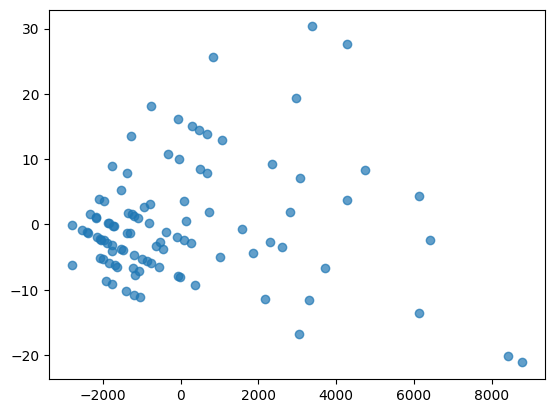

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

mutable_features = [i > 1 for i in mapocam.feas_grid_size]
Xts_mutable = Xts.iloc[:, mutable_features]

pca = PCA(n_components=2)
pca.fit(Xts_mutable)
Xts_mutable_pca = pca.transform(Xts_mutable)


plt.scatter(Xts_mutable_pca[:, 0], Xts_mutable_pca[:, 1], alpha=0.7)
7

In [60]:
def check_diff_solutions(solutions_1, solutions_2):
    if len(solutions_1) != len(solutions_2):
        return True
    
    for sol_1 in solutions_1:
        for sol_2 in solutions_2:
            if not np.all(sol_1 == sol_2):
                return True
            
    return False

X does not have valid feature names, but PCA was fitted with feature names


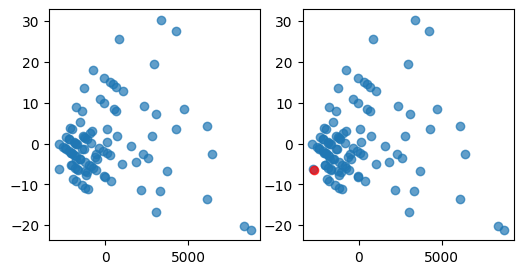

X does not have valid feature names, but PCA was fitted with feature names


------------------


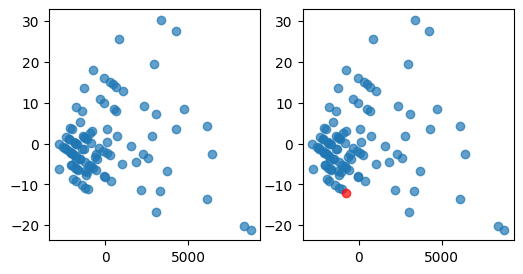

------------------


X does not have valid feature names, but PCA was fitted with feature names
X does not have valid feature names, but PCA was fitted with feature names


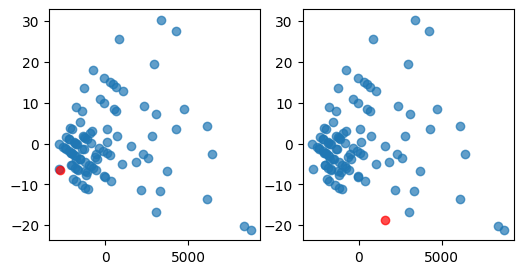

------------------


X does not have valid feature names, but PCA was fitted with feature names


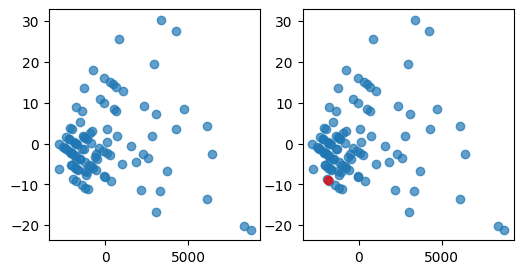

------------------


X does not have valid feature names, but PCA was fitted with feature names
X does not have valid feature names, but PCA was fitted with feature names


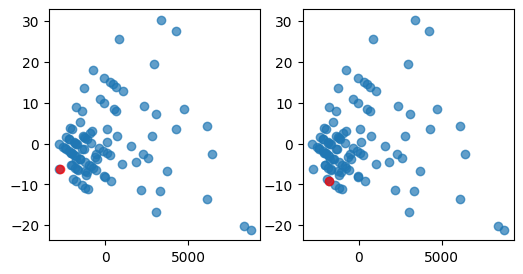

------------------


X does not have valid feature names, but PCA was fitted with feature names


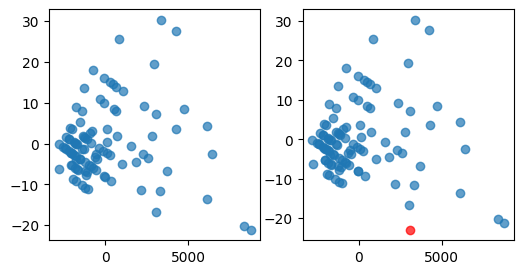

------------------


X does not have valid feature names, but PCA was fitted with feature names
X does not have valid feature names, but PCA was fitted with feature names


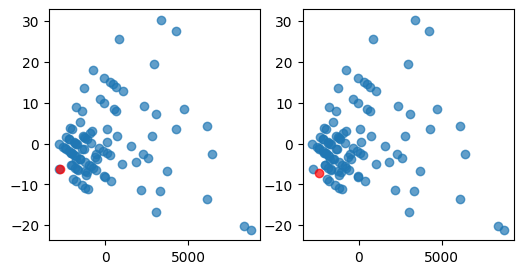

------------------


In [61]:
for i in range(len(denied_individuals_lgr)):
    #print("MAPOCAM1 solutions:", mapocam1_solutions[i])
    #print("MAPOCAM2 solutions:", mapocam2_solutions[i])
    #print("MAPOCAM2 solutions with outlier detection:", mapocam2_solutions_outlier[i])
    if not check_diff_solutions(mapocam1_solutions[i], mapocam2_solutions[i]):
        continue

    fig, axs = plt.subplots(1, 2, figsize = (6, 3))
    axs[0].scatter(Xts_mutable_pca[:, 0], Xts_mutable_pca[:, 1], alpha=0.7)
    axs[1].scatter(Xts_mutable_pca[:, 0], Xts_mutable_pca[:, 1], alpha=0.7)
    axs[0].set_title("MAPOCAM1")
    axs[1].set_title("MAPOCAM2")
    axs.suptitle("Comparison of solutions (PCA proj)")

    for sol in mapocam1_solutions[i]:
        sol_mutable = np.array(sol)[mutable_features]
        sol_mutable_pca = pca.transform(sol_mutable.reshape(1, -1))
        axs[0].scatter(sol_mutable_pca[:, 0], sol_mutable_pca[:, 1], c='red', alpha=0.7)

    for sol in mapocam2_solutions[i]:
        sol_mutable = np.array(sol)[mutable_features]
        sol_mutable_pca = pca.transform(sol_mutable.reshape(1, -1))
        axs[1].scatter(sol_mutable_pca[:, 0], sol_mutable_pca[:, 1], c='red', alpha=0.7)

    plt.show()

In [82]:
for i in range(len(mapocam1_solutions)):
    if len(mapocam1_solutions[i]) != len(mapocam2_solutions[i]):
        print(i)
        print("MAPOCAM1 solutions:")
        for sol in mapocam1_solutions[i]:
            print(list(zip(Xtr.columns, sol)))

        if len(mapocam1_solutions[i]) == 0:
            print("No solution")
        
        print("MAPOCAM2 solutions:")
        for sol in mapocam2_solutions[i]:
            print(list(zip(Xtr.columns, sol)))

        if len(mapocam2_solutions[i]) == 0:
            print("No solution")

        print("-------")

0
MAPOCAM1 solutions:
No solution
MAPOCAM2 solutions:
[('ForeignWorker', 0), ('Single', 0), ('Age', 29), ('LoanDuration', 6), ('LoanAmount', 1801), ('LoanRateAsPercentOfIncome', 2), ('isMale', 0), ('YearsAtCurrentHome', 4), ('NumberOfOtherLoansAtBank', 1), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 0)]
-------
1
MAPOCAM1 solutions:
No solution
MAPOCAM2 solutions:
[('ForeignWorker', 0), ('Single', 0), ('Age', 34), ('LoanDuration', 6), ('LoanAmount', 425), ('LoanRateAsPercentOfIncome', 4), ('isMale', 0), ('YearsAtCurrentHome', 4), ('NumberOfOtherLoansAtBank', 2), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 0)]
-------
2
MAPOCAM1 solutions:
No solution
MAPOCAM2 solutions:
[('ForeignWorker', 0), ('Single', 1), ('Age', 31), ('LoanDuration', 6), ('LoanAmount', 425), ('LoanRateAsPercentOfIncome', 4), ('isMale', 1), ('YearsAtCurrentHome', 4), ('NumberOfOtherLoansAtBank', 1), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 0)]
-------
3
MAPOCAM1 solutions:
No solution
MAPOCAM2

In [83]:
for i in range(len(mapocam1_solutions)):
    if len(mapocam2_solutions[i]) != len(mapocam2_solutions_outlier[i]):
        print(i)
        print("MAPOCAM2 solutions:")
        for sol in mapocam2_solutions[i]:
            print(list(zip(Xtr.columns, sol)))

        if len(mapocam2_solutions[i]) == 0:
            print("No solution")
        
        print("MAPOCAM2 with outlier detection solutions:")
        for sol in mapocam2_solutions_outlier[i]:
            print(list(zip(Xtr.columns, sol)))

        if len(mapocam2_solutions_outlier[i]) == 0:
            print("No solution")

        print("-------")

25
MAPOCAM2 solutions:
[('ForeignWorker', 0), ('Single', 1), ('Age', 31), ('LoanDuration', 36), ('LoanAmount', 425), ('LoanRateAsPercentOfIncome', 1), ('isMale', 1), ('YearsAtCurrentHome', 3), ('NumberOfOtherLoansAtBank', 2), ('NumberOfLiableIndividuals', 2), ('HasTelephone', 1)]
MAPOCAM2 with outlier detection solutions:
No solution
-------
29
MAPOCAM2 solutions:
[('ForeignWorker', 0), ('Single', 0), ('Age', 53), ('LoanDuration', 30), ('LoanAmount', 425), ('LoanRateAsPercentOfIncome', 4), ('isMale', 0), ('YearsAtCurrentHome', 1), ('NumberOfOtherLoansAtBank', 1), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 1)]
MAPOCAM2 with outlier detection solutions:
No solution
-------
33
MAPOCAM2 solutions:
[('ForeignWorker', 0), ('Single', 0), ('Age', 24), ('LoanDuration', 6), ('LoanAmount', 425), ('LoanRateAsPercentOfIncome', 1), ('isMale', 0), ('YearsAtCurrentHome', 2), ('NumberOfOtherLoansAtBank', 1), ('NumberOfLiableIndividuals', 2), ('HasTelephone', 0)]
MAPOCAM2 with outlier detection 

## Counterfactuals RF

In [86]:
clf_rf_mapocam =  TreeClassifier(clf_rt, Xtr, ytr, threshold=threshold, use_predict_max=True)

In [89]:
individual = Xts.iloc[0].values

### MAPOCAM

In [95]:
criteria = PercentileCriterion(individual, percCalc_rt)
clf_rf_mapocam.fit(individual, action_set_tree)
mapocam = MAPOCAM(
    action_set_tree, 
    individual, 
    clf_rf_mapocam,
    max_changes=float('inf'), 
    compare=criteria
)
mapocam.fit()
print(mapocam.solutions[0])

[   0    0   29   17 5308    2    0    4    1    1    0]


### MAPOCAM2

In [92]:
clf_rf_shap = GeneralClassifier_Shap(clf_rt, X=Xtr, y=ytr, threshold=threshold)

PermutationExplainer explainer: 901it [01:04, 11.61it/s]                         


In [93]:
criteria = PercentileCriterion(individual, percCalc_rt)
mapocam = MAPOCAM2(
    action_set_tree, 
    individual, 
    clf_rf_shap, 
    #outlier_detection,
    max_changes=float('inf'), 
    compare=criteria
)
mapocam.fit()
mapocam.solutions

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

[array([   0,    0,   29,   17, 5308,    2,    0,    4,    1,    1,    0])]

### Mapocam 2 with outlier detection

In [94]:
criteria = PercentileCriterion(individual, percCalc_rt)
mapocam = MAPOCAM2(
    action_set_tree, 
    individual, 
    clf_rf_shap, 
    outlier_detection,
    max_changes=float('inf'), 
    compare=criteria
)
mapocam.fit()
mapocam.solutions

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

[array([   0,    0,   29,   17, 5308,    2,    0,    4,    1,    1,    0])]

**Find a different solution**

In [ ]:
mapocam1_solutions = []
mapocam2_solutions = []
mapocam2_solutions_outlier = []
for i in denied_individuals_lgr:
    individual = Xts.iloc[i].values
    criteria = PercentileCriterion(individual, percCalc_rt)
    clf_rf_mapocam.fit(individual, action_set_tree)
    mapocam = MAPOCAM(
        action_set_tree, 
        individual, 
        clf_lgr_mapocam,
        max_changes=float('inf'), 
        compare=criteria
    )
    mapocam.fit()
    mapocam1_solutions.append(mapocam.solutions)

    mapocam = MAPOCAM2(
        action_set_tree, 
        individual, 
        clf_rf_shap, 
        #outlier_detection,
        max_changes=float('inf'), 
        compare=criteria
    )
    mapocam.fit()
    mapocam2_solutions.append(mapocam.solutions)

    mapocam = MAPOCAM2(
        action_set_tree, 
        individual, 
        clf_rf_shap, 
        outlier_detection,
        max_changes=float('inf'), 
        compare=criteria
    )
    mapocam.fit()
    mapocam2_solutions_outlier.append(mapocam.solutions)
    

In [104]:
for i in range(len(mapocam1_solutions)):
    if len(mapocam1_solutions[i]) == 1:
        print(Xts.iloc[denied_individuals_lgr[i]].values)
        print(list(zip(Xtr.columns, mapocam1_solutions[i][0])))
        print(list(zip(Xtr.columns, mapocam2_solutions[i][0])))
        print("---------")

[   0    0   29   24 7758    2    0    4    1    1    0]
[('ForeignWorker', 0), ('Single', 0), ('Age', 29), ('LoanDuration', 12), ('LoanAmount', 3444), ('LoanRateAsPercentOfIncome', 1), ('isMale', 0), ('YearsAtCurrentHome', 4), ('NumberOfOtherLoansAtBank', 1), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 0)]
[('ForeignWorker', 0), ('Single', 0), ('Age', 29), ('LoanDuration', 17), ('LoanAmount', 5308), ('LoanRateAsPercentOfIncome', 2), ('isMale', 0), ('YearsAtCurrentHome', 4), ('NumberOfOtherLoansAtBank', 1), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 0)]
---------
[   0    0   34   36 4454    4    0    4    2    1    0]
[('ForeignWorker', 0), ('Single', 0), ('Age', 34), ('LoanDuration', 12), ('LoanAmount', 1335), ('LoanRateAsPercentOfIncome', 3), ('isMale', 0), ('YearsAtCurrentHome', 4), ('NumberOfOtherLoansAtBank', 2), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 0)]
[('ForeignWorker', 0), ('Single', 0), ('Age', 34), ('LoanDuration', 36), ('LoanAmount', 3913), ('Lo

In [106]:
for i in range(len(mapocam2_solutions)):
    if len(mapocam2_solutions[i]) == 1:
        print(Xts.iloc[denied_individuals_lgr[i]].values)
        print(list(zip(Xtr.columns, mapocam2_solutions[i][0])))
        if len(mapocam2_solutions_outlier[i]) == 1:
            print(list(zip(Xtr.columns, mapocam2_solutions_outlier[i][0])))
        else:
            print("NO SOLUTION")
        print("---------")

[   0    0   29   24 7758    2    0    4    1    1    0]
[('ForeignWorker', 0), ('Single', 0), ('Age', 29), ('LoanDuration', 17), ('LoanAmount', 5308), ('LoanRateAsPercentOfIncome', 2), ('isMale', 0), ('YearsAtCurrentHome', 4), ('NumberOfOtherLoansAtBank', 1), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 0)]
[('ForeignWorker', 0), ('Single', 0), ('Age', 29), ('LoanDuration', 17), ('LoanAmount', 5308), ('LoanRateAsPercentOfIncome', 2), ('isMale', 0), ('YearsAtCurrentHome', 4), ('NumberOfOtherLoansAtBank', 1), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 0)]
---------
[   0    0   34   36 4454    4    0    4    2    1    0]
[('ForeignWorker', 0), ('Single', 0), ('Age', 34), ('LoanDuration', 36), ('LoanAmount', 3913), ('LoanRateAsPercentOfIncome', 4), ('isMale', 0), ('YearsAtCurrentHome', 4), ('NumberOfOtherLoansAtBank', 2), ('NumberOfLiableIndividuals', 1), ('HasTelephone', 0)]
[('ForeignWorker', 0), ('Single', 0), ('Age', 34), ('LoanDuration', 36), ('LoanAmount', 3913), ('Lo